# Import and misc

In [273]:
#!g2.mig
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
import pytorch_lightning as pl

pl.seed_everything(228)

Global seed set to 228


228

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [274]:
#!g2.mig
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [275]:
#!g2.mig
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [276]:
#!g2.mig
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [277]:
#!g2.mig
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [278]:
#!g2.mig
dataset.csv.sample(5)

,path,keyword,label
43061,speech_commands/five/a2fefcb4_nohash_1.wav,five,0
17022,speech_commands/tree/eefd26f3_nohash_0.wav,tree,0
31537,speech_commands/three/b433332a_nohash_3.wav,three,0
10654,speech_commands/one/b959cd0c_nohash_1.wav,one,0
54871,speech_commands/four/34e8c726_nohash_1.wav,four,0


### Augmentations

In [279]:
#!g2.mig
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [280]:
#!g2.mig
pl.seed_everything(228)

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

Global seed set to 228


In [281]:
#!g2.mig
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [282]:
#!g2.mig
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [283]:
#!g2.mig
train_sampler = get_sampler(train_set.csv['label'].values)

In [284]:
#!g2.mig
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [285]:
#!g2.mig
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=4, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [286]:
#!g2.mig
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [287]:
#!g2.mig
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [288]:
#!g2.mig
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [289]:
#!g2.mig
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [290]:
#!g2.mig
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input, all_layers_out=False):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        if all_layers_out:
            return output, [conv_output, gru_output, contex_vector]
        else:
            return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [291]:
#!g2.mig
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [292]:
#!g2.mig
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [293]:
#!g2.mig
sum([p.numel() for p in model.parameters()])

25387

In [294]:
#!g2.mig
history

defaultdict(list, {})

In [295]:
#!g2.mig

from dataclasses import field

@dataclasses.dataclass
class DistillationConfig:
    t: float = 10.0
    weights: List[float] = field(default_factory=lambda: [0.2, 0.005, 0.01, 0.2])
    proj_dim: int = 10
    

class Distiller(nn.Module):
    def __init__(self, config, student, teacher, sample_batch):
        super().__init__()
        
        self.config = config
        self.student = student
        self.teacher = teacher
        
        _, l_s = self.student(sample_batch, all_layers_out=True)
        _, l_t = self.teacher(sample_batch, all_layers_out=True)
        
        self.proj_s, self.proj_t = [], []
        for x_s, x_t in zip(l_s, l_t):
            self.proj_s.append(nn.Linear(x_s.shape[-1], config.proj_dim))
            self.proj_t.append(nn.Linear(x_t.shape[-1], config.proj_dim))
            
        self.proj_s = nn.ModuleList(self.proj_s)
        self.proj_t = nn.ModuleList(self.proj_t)
        
    def forward(self, x):
        with torch.no_grad():
            logits_t, layers_t = self.teacher(x, all_layers_out=True)
        logits_s, layers_s = self.student(x, all_layers_out=True)
        
        t = self.config.t
        loss = self.config.weights[0] * F.mse_loss(torch.softmax(logits_s / t, dim=-1), torch.softmax(logits_t / t, dim=-1))
        for w, x_s, x_t, proj_s, proj_t in zip(self.config.weights, layers_s, layers_t, self.proj_s, self.proj_t):
            # print('!!!', x_s.shape, x_t.shape)
            loss += w * F.mse_loss(proj_s(x_s.reshape(-1, x_s.shape[-1])), proj_t(x_t.reshape(-1, x_t.shape[-1])))
            
        return logits_s, loss

In [296]:
#!g2.mig
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

def train_epoch_distillation(distiller, opt, loader, log_melspec, device, alpha=0.5):
    model.train()
    
    stats = defaultdict(float)
    n_batches = 0
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits, distillation_loss = distiller(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = alpha * F.cross_entropy(logits, labels)
        stats['loss_classification']  = loss.detach().cpu().item()
        stats['loss_distillation']  = distillation_loss.detach().cpu().item()
        
        loss += (1 - alpha) * distillation_loss
        
        stats['loss']  = loss.detach().cpu().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        n_batches += 1

    return stats

In [297]:
#!g2.mig
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [298]:
#!g2.mig
import tempfile
from thop import profile
import copy

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

def get_macs(model, batch):
    tmp = copy.deepcopy(model)
    return profile(tmp, (batch,))[0]

def get_model_score(base_model, model, batch):
    cr = get_size_in_megabytes(base_model) / get_size_in_megabytes(model)
    sr = get_macs(base_model, batch) / get_macs(model, batch)
    
    print('CR: {:.3f}, SR: {:.3f}, Score: {:.3f}/7.000'.format(cr, sr, 0.35 * (sr + cr)))

# Попробуем разные гиперпараметры модели и обучения

In [299]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=4)

model = CRNN(config).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig()
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 2.640, SR: 2.449, Score: 1.781/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(72, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


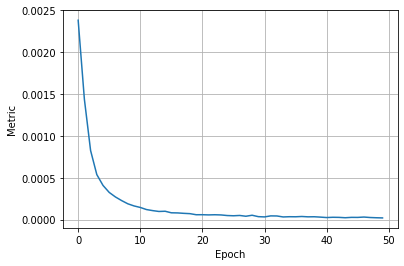

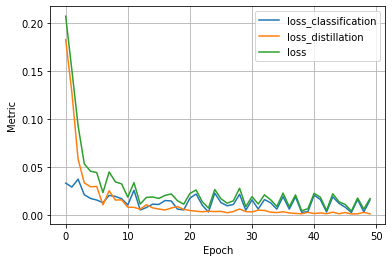

Saved model with metric 2.0963994652480614e-05
defaultdict(<class 'float'>, {'loss_classification': 0.016073239967226982, 'loss_distillation': 0.001562200952321291, 'loss': 0.017557330429553986, 'au_fa_fr': 2.0963994652480614e-05})
END OF EPOCH 49
Best: 2.0963994652480614e-05


In [300]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_conv_out_4_hs_20.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [301]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=4,
    kernel_size=(20, 20,),
    stride=(10, 8,))

model = CRNN(config).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=[0.4, 0.01, 0.02, 0.4])
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 3.481, SR: 3.909, Score: 2.586/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(20, 20), stride=(10, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(12, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
      

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


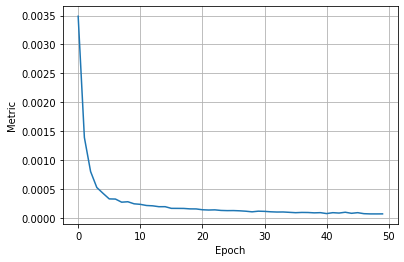

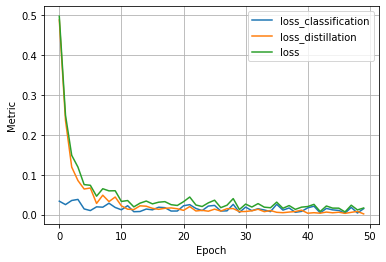

defaultdict(<class 'float'>, {'loss_classification': 0.014963327907025814, 'loss_distillation': 0.001782675157301128, 'loss': 0.016656870022416115, 'au_fa_fr': 7.878654693975954e-05})
END OF EPOCH 49
Best: 7.807939255139662e-05


In [302]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_conv_out_4_hs_20_kernel_20_20_stride_10_10.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [303]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=8,
    stride=(5, 8,),
    kernel_size=(10, 20,)
)

model = CRNN(config)

model.to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=[0.2, 0.005, 0.01, 0.2])
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 2.578, SR: 2.059, Score: 1.623/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(10, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(56, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
       

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


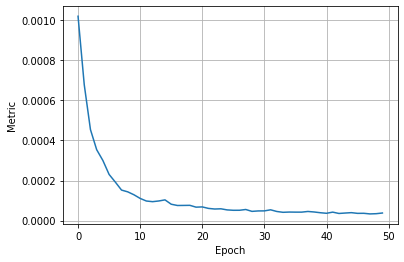

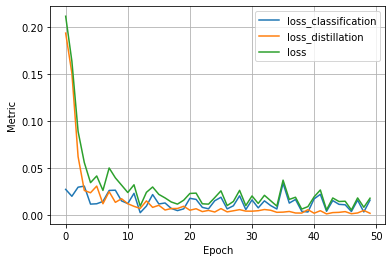

defaultdict(<class 'float'>, {'loss_classification': 0.016166750341653824, 'loss_distillation': 0.0021660644561052322, 'loss': 0.018224511295557022, 'au_fa_fr': 3.778651128366275e-05})
END OF EPOCH 49
Best: 3.3275045312334724e-05


In [304]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_conv_out_8_hs_20_kernel_10_20_stride_5_8.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [305]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,)
)

model = CRNN(config)

model.to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=[0.2, 0.005, 0.01, 0.2])
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 3.481, SR: 4.070, Score: 2.643/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(32, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


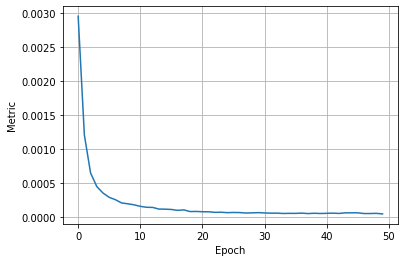

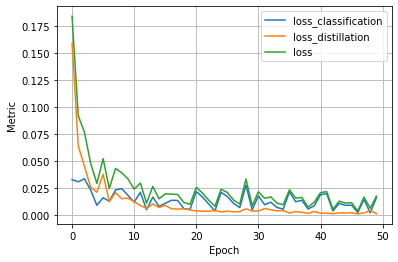

Saved model with metric 5.0467549893546405e-05
defaultdict(<class 'float'>, {'loss_classification': 0.016224609687924385, 'loss_distillation': 0.0015929787186905742, 'loss': 0.017737939953804016, 'au_fa_fr': 5.0467549893546405e-05})
END OF EPOCH 49
Best: 5.0467549893546405e-05


In [306]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_conv_out_4_hs_20_kernel_5_20_stride_5_8.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [307]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
)

model = CRNN(config)

model.to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=[0.2, 0.005, 0.01, 0.2])
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 3.481, SR: 4.070, Score: 2.643/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(32, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


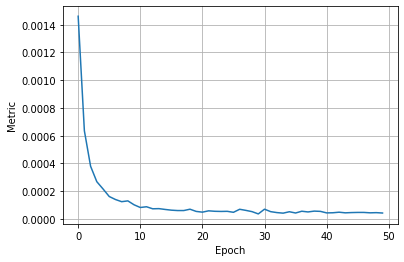

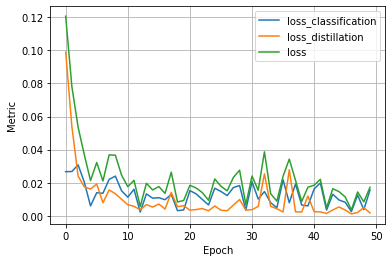

defaultdict(<class 'float'>, {'loss_classification': 0.01558029092848301, 'loss_distillation': 0.0017093241913244128, 'loss': 0.017204148694872856, 'au_fa_fr': 4.238152292112648e-05})
END OF EPOCH 49
Best: 3.590673379560941e-05


In [308]:
#!g2.mig
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_conv_out_4_hs_20_kernel_5_20_stride_5_8.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

# Попробуем заменить GRU на RNN и подобрать гиперпараметры

In [309]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig()
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 7.095, SR: 7.044, Score: 4.949/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(32, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


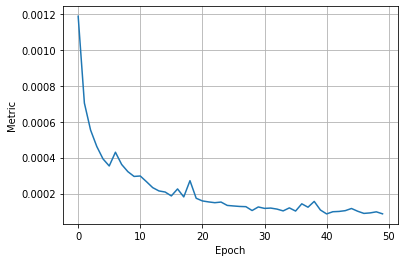

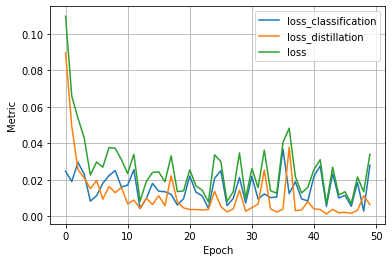

defaultdict(<class 'float'>, {'loss_classification': 0.028004541993141174, 'loss_distillation': 0.006343128625303507, 'loss': 0.03403051570057869, 'au_fa_fr': 8.672636899644201e-05})
END OF EPOCH 49
Best: 8.627283538027676e-05


In [310]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [311]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=24,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=[0.2, 0.005, 0.01, 0.2])
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 5.772, SR: 6.104, Score: 4.156/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(32, 24, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=24, out_features=24, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


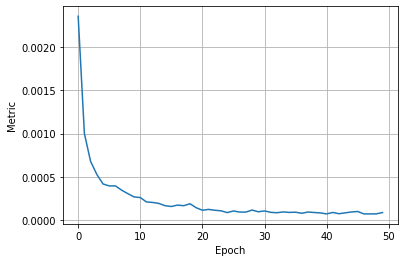

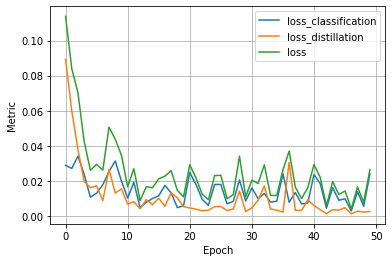

defaultdict(<class 'float'>, {'loss_classification': 0.023948485031723976, 'loss_distillation': 0.0026288868393749, 'loss': 0.02644592709839344, 'au_fa_fr': 9.076043116128028e-05})
END OF EPOCH 49
Best: 7.500610554711894e-05


In [312]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn.pt'

for n in range(50):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.05)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [313]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=24,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
    weight_decay=0,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=np.array([0.2, 0.005, 0.01, 0.2]) * 2)
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 5.772, SR: 6.104, Score: 4.156/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(32, 24, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=24, out_features=24, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


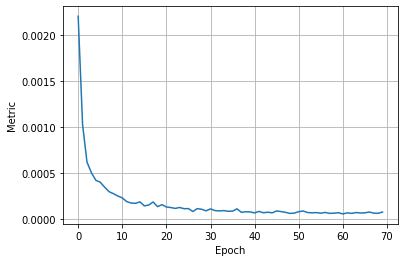

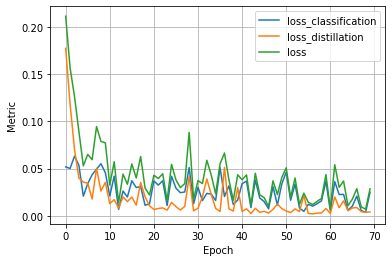

defaultdict(<class 'float'>, {'loss_classification': 0.024852918460965157, 'loss_distillation': 0.004020501859486103, 'loss': 0.028471369296312332, 'au_fa_fr': 7.861050428611645e-05})
END OF EPOCH 69
Best: 5.852373912806074e-05


In [314]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn.pt'

for n in range(70):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.1)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [315]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=24,
    cnn_out_channels=8,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=np.array([0.2, 0.005, 0.01, 0.2]) * 2)
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 4.592, SR: 3.778, Score: 2.929/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(64, 24, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=24, out_features=24, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


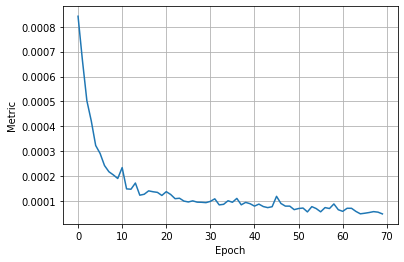

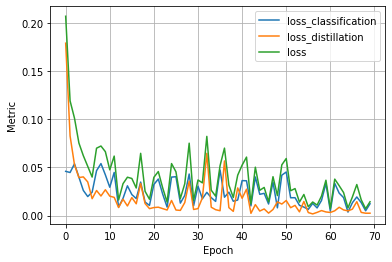

Saved model with metric 4.821181690788241e-05
defaultdict(<class 'float'>, {'loss_classification': 0.012169792316854, 'loss_distillation': 0.0023941779509186745, 'loss': 0.01432455237954855, 'au_fa_fr': 4.821181690788241e-05})
END OF EPOCH 69
Best: 4.821181690788241e-05


In [316]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn_2.pt'

for n in range(70):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.1)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [320]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=24,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
    weight_decay=0,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

model.load_state_dict(torch.load('base_rnn.pt').state_dict())

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=np.array([0.2, 0.005, 0.01, 0.2]) * 2)
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 5.772, SR: 6.104, Score: 4.156/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(32, 24, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=24, out_features=24, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


In [321]:
#!g2.mig
validation(model, val_loader, melspec_val, config.device)

102it [00:04, 25.17it/s]


5.852373912806074e-05

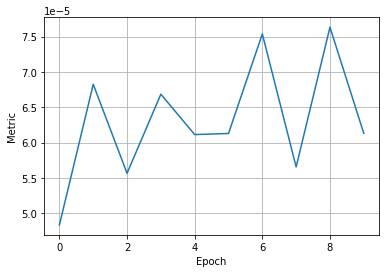

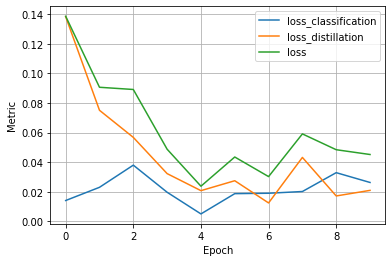

defaultdict(<class 'float'>, {'loss_classification': 0.02632310800254345, 'loss_distillation': 0.020984331145882607, 'loss': 0.04520900547504425, 'au_fa_fr': 6.129864875328233e-05})
END OF EPOCH 9


 99%|█████████▉| 400/405 [00:48<00:00,  8.24it/s]


KeyboardInterrupt: 

In [322]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn_3.pt'

for n in range(150):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.1)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)

    print('END OF EPOCH', n)
    
print('Best:', best_metric)

In [323]:
#!g2.mig

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

model.load_state_dict(torch.load('base_rnn_3.pt').state_dict())

validation(model, val_loader, melspec_val, config.device)

102it [00:07, 13.23it/s]


4.8337135407085956e-05

In [326]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=4,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
    weight_decay=0,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=np.array([0.2, 0.005, 0.01, 0.2]) * 2)
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 7.095, SR: 7.044, Score: 4.949/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(32, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


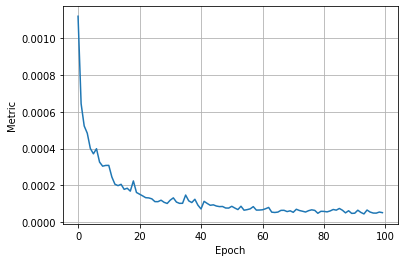

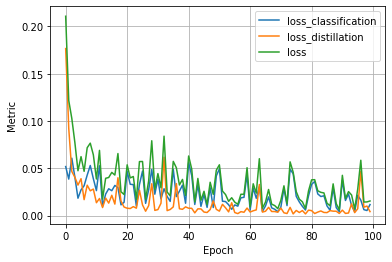

defaultdict(<class 'float'>, {'loss_classification': 0.011684317141771317, 'loss_distillation': 0.0042064911685884, 'loss': 0.015470159240067005, 'au_fa_fr': 5.213249566867937e-05})
Best: 4.5305621235876124e-05
END OF EPOCH 99


In [327]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn_4.pt'

for n in range(100):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.1)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)
    print('Best:', best_metric)
    
    print('END OF EPOCH', n)

In [340]:
#!g2.mig
pl.seed_everything(228)

history = defaultdict(list)

config = TaskConfig(
    hidden_size=20,
    cnn_out_channels=3,
    stride=(5, 8,),
    kernel_size=(5, 20,),
    learning_rate=6e-4,
    weight_decay=0,
)

model = CRNN(config).to(config.device)

model.gru = nn.RNN(
    input_size=model.conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
).to(config.device)

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

distiller_config = DistillationConfig(weights=np.array([0.2, 0.005, 0.01, 0.2]) * 2)
sample_batch = melspec_train(torch.rand((1, config.sample_rate)).to(config.device))
distiller = Distiller(distiller_config, model, base_model, sample_batch).to(config.device)

get_model_score(base_model, model, sample_batch)

print(distiller)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 7.623, SR: 8.507, Score: 5.645/7.000
Distiller(
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 3, kernel_size=(5, 20), stride=(5, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): RNN(24, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


In [341]:
#!g2.mig
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

dataset[0]

{'wav': tensor([ 0.0044,  0.0048,  0.0056,  ..., -0.0068, -0.0059, -0.0060]),
 'keywors': 'eight',
 'label': 0}

In [350]:
#!g2.mig
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler, num_workers=4)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(), num_workers=4)

In [351]:
#!g2.mig
next(iter(train_loader))

(tensor([[-1.0343e-02,  1.0318e-02,  1.0143e-02,  ..., -6.7497e-03,
          -9.8367e-04,  7.6373e-03],
         [ 6.3324e-04,  7.2479e-04,  7.6294e-04,  ...,  1.1673e-03,
           1.2970e-03,  1.2741e-03],
         [ 4.1528e-03, -2.0556e-03, -1.6924e-03,  ..., -2.9104e-03,
          -4.2050e-04,  1.3760e-04],
         ...,
         [-1.5602e-04,  1.7402e-03,  3.4225e-03,  ..., -5.3442e-03,
          -1.1569e-03, -1.8306e-03],
         [ 1.1617e-03,  6.7727e-04,  4.9065e-04,  ..., -6.9232e-05,
           2.1935e-03,  3.2144e-03],
         [-6.1035e-05, -6.1035e-05, -6.1035e-05,  ..., -6.1035e-05,
          -3.0518e-05, -3.0518e-05]]),
 tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
         1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 0, 1, 

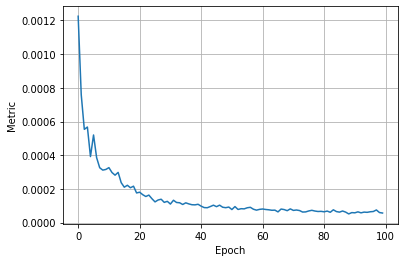

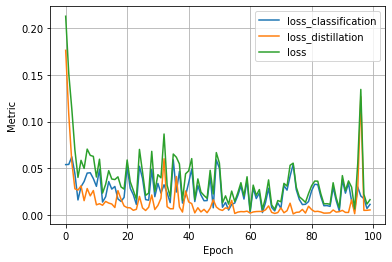

defaultdict(<class 'float'>, {'loss_classification': 0.011555212549865246, 'loss_distillation': 0.005591501947492361, 'loss': 0.01658756472170353, 'au_fa_fr': 5.697217675696909e-05})
Best: 5.170283224283861e-05
END OF EPOCH 99


In [352]:
#!g2.mig
pl.seed_everything(228)

best_metric = None
model_name = 'base_rnn_5.pt'

for n in range(100):
    stats = train_epoch_distillation(distiller, opt, train_loader, melspec_train, config.device, 0.1)

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    stats['au_fa_fr'] = au_fa_fr
    
    for k, v in stats.items():
        history[k].append(v)

    clear_output()
    plt.plot(history['au_fa_fr'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()
    
    plt.plot(history['loss_classification'], label='loss_classification')
    plt.plot(history['loss_distillation'], label='loss_distillation')
    plt.plot(history['loss'], label='loss')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    if best_metric is None or au_fa_fr < best_metric:
        best_metric = au_fa_fr
        torch.save(model, model_name)
        print('Saved model with metric', best_metric)
    
    print(stats)
    print('Best:', best_metric)
    
    print('END OF EPOCH', n)

In [359]:
#!g2.mig
def get_model_score_half(base_model, model, batch):
    cr = get_size_in_megabytes(base_model) / get_size_in_megabytes(copy.deepcopy(model).half())
    sr = get_macs(base_model, batch) / get_macs(model, batch)
    
    print('CR: {:.3f}, SR: {:.3f}, Score: {:.3f}/7.000'.format(cr, sr, 0.35 * (min(10, sr) + min(10, cr))))
    
@torch.no_grad()
def validation_half(model, loader, log_melspec, device):
    model = model.eval().half()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch).half()

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

# Добавим fp16 к лучшей модели

In [363]:
#!g2.mig
pl.seed_everything(228)

model = torch.load('base_rnn_5.pt')

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

get_model_score_half(base_model, model, sample_batch)

opt = torch.optim.Adam(
    distiller.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

with torch.no_grad():
    distiller(sample_batch)

Global seed set to 228


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 12.045, SR: 8.507, Score: 6.477/7.000


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


In [364]:
#!g2.mig
au_fa_fr = validation_half(model.half(), val_loader, melspec_val, config.device)
au_fa_fr

102it [00:07, 13.71it/s]


5.132090919764682e-05

In [365]:
#!g2.mig
next(iter(model.parameters())).type()

'torch.cuda.HalfTensor'

In [370]:
#!g2.mig
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

dataset[0]

{'wav': tensor([ 0.0044,  0.0048,  0.0056,  ..., -0.0068, -0.0059, -0.0060]),
 'keywors': 'eight',
 'label': 0}

In [406]:
#!g2.mig
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator())
next(iter(train_loader))

(tensor([[ 1.5259e-05,  1.5259e-05,  1.5259e-05,  ..., -5.3406e-05,
          -6.1035e-05, -8.3923e-05],
         [ 1.5259e-05,  6.8665e-05,  1.2207e-04,  ..., -7.6294e-05,
          -6.1035e-05, -9.1553e-05],
         [-3.6226e-02, -5.3749e-02, -4.3669e-02,  ..., -3.7732e-02,
          -6.1216e-02, -3.3628e-02],
         ...,
         [ 8.2397e-04,  2.6245e-03,  3.4180e-03,  ..., -7.6294e-04,
          -1.1902e-03, -1.4343e-03],
         [-8.1667e-03, -2.7156e-03,  1.4752e-03,  ...,  3.7722e-03,
           5.2425e-03, -7.3909e-04],
         [ 6.8940e-04, -8.8056e-03,  4.5047e-03,  ...,  2.5785e-03,
          -2.9818e-03, -4.2547e-03]]),
 tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
         0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
         0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
         0, 1, 1, 0, 0, 0, 0, 

In [410]:
#!g2.mig
pl.seed_everything(228)

model = torch.load('base_rnn_5.pt')

base_model = CRNN(TaskConfig(hidden_size=32)).to(config.device)
base_model.load_state_dict(torch.load('base_model.pt'))

get_model_score_half(base_model, model, sample_batch)
    
print(val_indexes)
print(train_indexes)

au_fa_fr = validation_half(model.half(), val_loader, melspec_val, config.device)
au_fa_fr

Global seed set to 228
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:837: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,
2it [00:00, 15.11it/s]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CR: 12.045, SR: 8.510, Score: 6.478/7.000
tensor([20317, 46260,  4665,  ..., 61251,  6623, 28722])
tensor([40169, 61937, 54708,  ..., 33714, 52841, 16231])


102it [00:10,  9.64it/s]


5.132090919764682e-05